In [8]:
# MSSG, based on JEM and LCA code
# NB version, Start: 12/2015

%pylab inline

### Generic imports
import lmfit
import ipdb
import sys
import random
#import triangle
from argparse import ArgumentParser
#import matplotlib.pyplot as plt
#import numpy as np

### Specific imports
import galsim
import mssg_deblend
import mssg_drawLibrary
from mssg_makeplot import *
from mssg_create_blend import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [82]:

###################################################### Function to create the blended img
def create_blend(peak_a, peak_b, flux_bTOa = 1, size_bTOa = 1, e1a = 0, e1b = 0 , e2a = 0, e2b = 0, imgsize = 0, pixelscale = 0, mrkrsize = 10):

    # Global vars
    randnum=galsim.BaseDeviate(1) # Random num seed -- when set to zero, uses machine time

    #### Level to do printing at (setting it lower will print more stuff)
    presetval = 2
    #    plotflag =  0  # The default, to plot the minimum
    plotflag =  1  # Print more
    
    # Create gaussian gal objs, sheared in various directions
    hlr_a = 1.0
    hlr_b = hlr_a * size_bTOa

    flux_a = 1e4
    flux_b = flux_a * flux_bTOa
    
    gal1 = galsim.Gaussian(half_light_radius= hlr_a , flux= flux_a).shear(g1=e1a, g2= e2a).shift(peak_a)
    gal2 = galsim.Gaussian(half_light_radius= hlr_b , flux= flux_b ).shear(g1=e1b, g2= e2b).shift(peak_b)
    
    # Add psf 
    psfshr = 0.00
    psf = galsim.Moffat(beta=3, fwhm=0.85).shear(e1 = psfshr,  e2 = -psfshr)

    convgal1 = galsim.Convolve([gal1,psf])
    convgal2 = galsim.Convolve([gal2,psf])
    
    # Now make imgs
#    imgsize = 49
#    pixelscale = 0.2
    imgcent = imgsize/2

    print "peak_a[0] = ", peak_a[0]
    print 'imgcent = ', imgcent
    acent = (imgcent+peak_a[0]/pixelscale, imgcent+peak_a[1]/pixelscale)
    bcent = (imgcent+peak_b[0]/pixelscale, imgcent+peak_b[1]/pixelscale)

    # Img1
    proto_image = galsim.ImageD(imgsize, imgsize, scale = pixelscale)
#    image1 = convgal1.drawImage(image=proto_image, method='phot', rng=randnum)
    image1 = convgal1.drawImage(image=proto_image)
    print '************** About to show plots with flux a = ', flux_a , ', flux_b = ', flux_b
#    print image1.array[np.where(image1.array < 0)] 
#    image1.array[np.where(image1.array < 0)] = 0.
    if plotflag > presetval:
        pltname =  " FIRST PLOT:  Img obj a"
        pltcontent =   image1.array 
        plt.title(" FIRST PLOT:  Img obj a")
        plt.imshow( image1.array , origin='lower', interpolation='none' );    
        plt.colorbar()
        plt.plot( acent[0], acent[1], color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        plt.show()
        print " >>>>>> Plotting img obj a"
        print " image1.array.sum() " , image1.array.sum()
        center = (peak_a, peak_b)

    # Img2
    proto_image = galsim.ImageD(imgsize, imgsize, scale = pixelscale)
#    image2 = convgal2.drawImage(image=proto_image, method='phot', rng=randnum)
    image2 = convgal2.drawImage(image=proto_image)
    image2.array[np.where(image2.array < 0)] = 0.    
    if plotflag > presetval: 
        plt.title(" Img obj b")
        print " >>>>>> Plotting img obj b"
        plt.imshow( image2.array , origin='lower',  interpolation='none' );    
        plt.colorbar()
        plt.plot(bcent[0], bcent[1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        plt.show()
    

### Add them into one image
    imagesum =  image1+image2    

    if plotflag > presetval:
        plt.title(" Img obj a + b")
        print " >>>>>> Plotting imgsum"
        plt.plot( acent[0], acent[1], color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        plt.plot(bcent[0], bcent[1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        
        plt.imshow( imagesum.array , origin='lower',  interpolation='none' );    
        plt.colorbar()
        plt.show()
        
    return imagesum, [image1, image2]


In [83]:
#################################################### Function to draw gal figs
def makeplot(pltname, pltcontent,  centre=(0,0) , colorbarlimit = 0, location = 'lower', mrkrsize = 10 ,qrtr = 0.25):


          plt.title(pltname)
          print " >>>>>> Plotting ", pltname          
          dummyarr = np.array([1, 2, 3])
          if type(pltcontent) != type(dummyarr):
              print pltcontent, " is not a numpy array, will convert"
              pltcontent = pltcontent.array
          
          vmin,vmax = np.percentile(pltcontent,[1,99])
          vmax = max(abs(vmin),abs(vmax))
          vmin = -vmax
        
          ysize,xsize = pltcontent.shape
        
          pltimg = plt.imshow( pltcontent , origin=location, interpolation='none', vmin = vmin, vmax=vmax );
          plt.xlim(qrtr*xsize,(1-qrtr)*xsize)
          plt.ylim(qrtr*ysize,(1-qrtr)*ysize)
          
          if colorbarlimit==1:
                    pltimg.set_clim(-1,1)
          plt.colorbar()
          if (centre[0] !=0 and centre[1] !=0):
                    plt.plot(centre[0][0], centre[0][1],  color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                    plt.plot(centre[1][0], centre[1][1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                
          plt.show()
    # plt.annotate
    

In [84]:
#################################################### Function to draw gal figs
def passplot(pltname, pltcontent, inax, centre=(0,0) , colorbarlimit = 0, location = 'lower', mrkrsize = 10 ,qrtr = 0.25):


          inax.set_title(pltname)
          print " >>>>>> Plotting ", pltname          
          dummyarr = np.array([1, 2, 3])
          if type(pltcontent) != type(dummyarr):
              print pltcontent, " is not a numpy array, will convert"
              pltcontent = pltcontent.array
          
          vmin,vmax = np.percentile(pltcontent,[1,99])
          vmax = max(abs(vmin),abs(vmax))
          vmin = -vmax
        
          ysize,xsize = pltcontent.shape
        
          pltimg = inax.imshow( pltcontent , origin=location, interpolation='none', vmin = vmin, vmax=vmax );
          inax.set_xlim(qrtr*xsize,(1-qrtr)*xsize)
          inax.set_ylim(qrtr*ysize,(1-qrtr)*ysize)
          '''  
          if colorbarlimit==1:
                    pltimg.set_clim(-1,1)
          inax.colorbar()
          '''
          if (centre[0] !=0 and centre[1] !=0):
                    inax.plot(centre[0][0], centre[0][1],  color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                    inax.plot(centre[1][0], centre[1][1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                
    # plt.annotate
    

In [85]:
################### Initze

#### Level to do printing at (setting it lower will print more stuff)
presetval = 1

plt.rcParams['image.cmap'] = 'seismic'


############################################################################# Main

# Parse command line args
parser = ArgumentParser()
parser.add_argument("--outfile", default="deblendsOutput/deblendingTests", help="output text filename")
parser.add_argument("--e1a", default=0, type=float, help="e1a in")
parser.add_argument("--e2a", default=0, type=float, help="e2a in")
parser.add_argument("--e1b", default=0, type=float, help="e1b in")
parser.add_argument("--e2b", default=0, type=float, help="e2b in")
parser.add_argument("--plotflag", default=0, type=int, help="Set to 1 to make plots")
parser.add_argument("--centers", default=1, type=int, help="Set to 1 to use exact centers, 2 to use centers from simfit")

args = parser.parse_args("")  # In ipynb, this makes the args be all the default args as above

########## Get ellips from cmd line
e1ain = args.e1a ; e2ain = args.e2a
e1bin = args.e1b ; e2bin = args.e2b

plotflag = args.plotflag
centers = args.centers

# ************************************************************************ 4 arcsec sep
# origpeak_a = (-2,0);   origpeak_b = (2,0)    
# ************************************************************************ 2 arcsec sep
origpeak_a = (-1,0);   origpeak_b = (1,0)    

################### Initze

peak_a =  np.array(origpeak_a) ; peak_b =  np.array(origpeak_b) 
# print " \n\n\n peak_a = ",  peak_a 

########  Convert peaks_pix to pixels
peaks_pix = [[p1/0.2 for p1 in peak_a],  # Div by 0.2 to convert back to pixels
             [p2/0.2 for p2 in peak_b]]

print " ******************************* Peaks are at: "
print " In Arcsec: peaks_A = " , peak_a
print " In Arcsec: peaks_B = " , peak_b

print "\n Pixels: peaks in pixels = " ,  peaks_pix

# print " Pixels: peaks_pix[0] = " ,  peaks_pix[0][0] 

########### Img params
imsize = 101
pixel_scale = 0.2

################## Create the blended obj    
blend, unblends = create_blend(peak_a, peak_b, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)

if plotflag > presetval:
    plt.title(" Sanity check: Img blended obj - (a+b) ")
    print " >>>>>> Plotting blend.array - (unblends[0].array + unblends[1].array)  "
    plt.imshow( blend.array - (unblends[0].array + unblends[1].array) , origin='lower',  interpolation='none' );    
    plt.colorbar()
    plt.show()


########################## Using actual known peaks, to compare
if centers == 1:
    curpeak_a = origpeak_a ;   curpeak_b = origpeak_b

#    ipdb.set_trace()

#  Convert peaks_pix to pixels
peaks_pix = [[p1/0.2 for p1 in curpeak_a],  # Div by 0.2 to convert back to pixels
                         [p2/0.2 for p2 in curpeak_b]]

print " \n\n\n  ************************* About to deblend with these centers: "   
print " Arcsec: peaks_A = " , peak_a
print " Arcsec: peaks_B = " , peak_b
print " Pixels: peaks_pix = " ,  peaks_pix 

################################################################# Assign to actual peak variable
peak_a =  np.array(curpeak_a) ; peak_b =  np.array(curpeak_b) 
peaks_pix = [[p1/0.2 for p1 in peak_a],  # Div by 0.2 to convert back to pixels
                         [p2/0.2 for p2 in peak_b]]

templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)

##### Needed to plot points at center of imgs
imgsize = imsize
pixelscale = pixel_scale 
imgcent = imgsize/2
acent = (imgcent+peak_a[0]/pixelscale, imgcent+peak_a[1]/pixelscale)
bcent = (imgcent+peak_b[0]/pixelscale, imgcent+peak_b[1]/pixelscale)

center= (acent,bcent)
print "center[0][0] = ",center[0][0]
print "center[0][1] = ",center[0][1]
print "center[1][0] = ",center[1][0]
print "center[1][1] = ",center[1][1] 

########## Plot template
if plotflag > presetval:
    pltname = " Template obj a "
    pltcontent = template_fractions[0] 
    makeplot(pltname, pltcontent, centre=center)

######### Plot children
    ### Obj a
  
    peakval = unblends[0].array[acent[0], acent[1]]
    print " peakval = ", peakval
 
if plotflag > presetval-2:
    print "Plotting resid"
    pltname = " Resid of: (Deblended child a - Unblended img a) / peak val of a ";        
    pltcontent = (children[0] - unblends[0].array)/  peakval

#   makeplot(pltname, pltcontent, centre=center)
;

 ******************************* Peaks are at: 
 In Arcsec: peaks_A =  [-1  0]
 In Arcsec: peaks_B =  [1 0]

 Pixels: peaks in pixels =  [[-5.0, 0.0], [5.0, 0.0]]
peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  10000.0
 


  ************************* About to deblend with these centers: 
 Arcsec: peaks_A =  [-1  0]
 Arcsec: peaks_B =  [1 0]
 Pixels: peaks_pix =  [[-5.0, 0.0], [5.0, 0.0]]
center[0][0] =  45.0
center[0][1] =  50.0
center[1][0] =  55.0
center[1][1] =  50.0
Plotting resid


''

peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  10000.0
 >>>>>> Plotting  Flux b/a = 1, Size b/a = 1


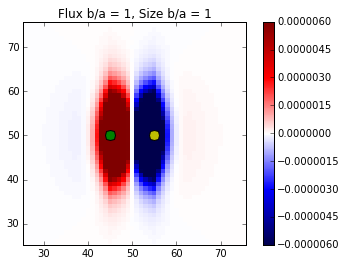

peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  5000.0
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1


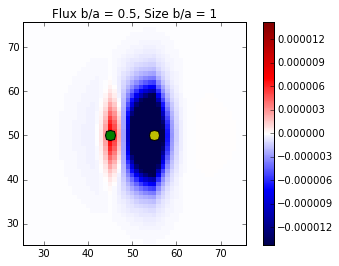

peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  2000.0
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1


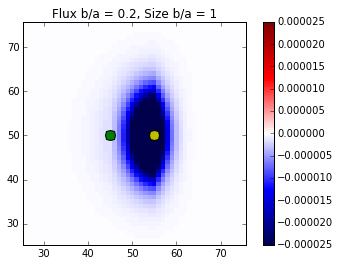

peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  10000.0
 >>>>>> Plotting  Flux b/a = 1, Size b/a = 1.5


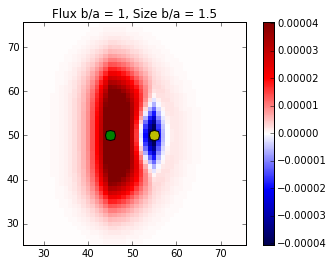

peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  5000.0
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.5


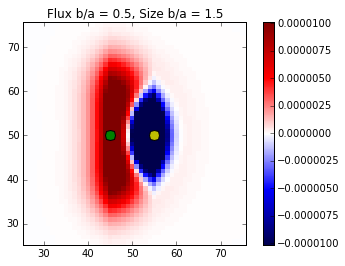

peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  2000.0
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.5


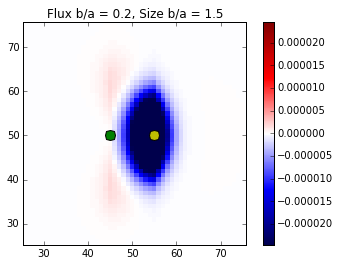

In [86]:

##################

flux_bTOa = 1
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(231)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
makeplot(pltname, pltcontent,  centre=center)

flux_bTOa = 0.5
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(232)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
makeplot(pltname, pltcontent,  centre=center)

flux_bTOa = 0.2
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa = flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(233)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
makeplot(pltname, pltcontent,  centre=center)

###########

flux_bTOa = 1
size_bTOa = 1.5
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(234)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
makeplot(pltname, pltcontent,  centre=center)

flux_bTOa = 0.5
size_bTOa = 1.5
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(235)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
makeplot(pltname, pltcontent,  centre=center)

flux_bTOa = 0.2
size_bTOa = 1.5
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa = flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(236)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
makeplot(pltname, pltcontent,  centre=center)



peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  10000.0
 >>>>>> Plotting  Flux b/a = 1, Size b/a = 1
peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  5000.0
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1
peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  2000.0
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1
peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  10000.0
 >>>>>> Plotting  Flux b/a = 1, Size b/a = 1.5
peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  5000.0
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.5
peak_a[0] =  -1
imgcent =  50
************** About to show plots with flux a =  10000.0 , flux_b =  2000.0
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.5


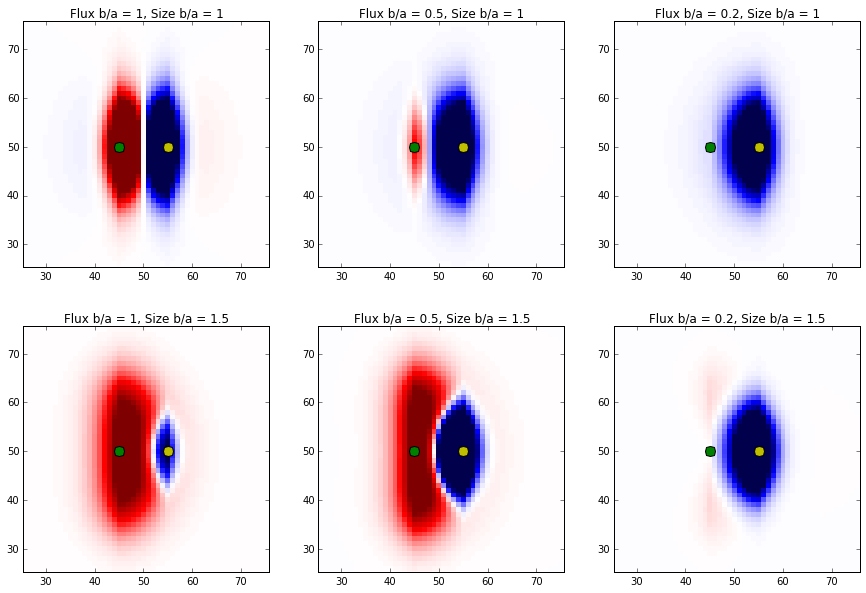

In [87]:
fig = plt.figure(figsize = (15,10))

##################

flux_bTOa = 1
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(231)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center)

flux_bTOa = 0.5
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(232)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center)

flux_bTOa = 0.2
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa = flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(233)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center)

###########

flux_bTOa = 1
size_bTOa = 1.5
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(234)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center)

flux_bTOa = 0.5
size_bTOa = 1.5
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(235)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center)

flux_bTOa = 0.2
size_bTOa = 1.5
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa = flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
pltcontent = (children[0] - unblends[0].array)/  peakval
ax = fig.add_subplot(236)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center)



In [55]:
plt.show()